## CE-like background in offspill 

SAM definition: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root` 

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

Switched to using installed pyutils package

In [40]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import gc
import sys
from datetime import datetime
# Get today's date in MM-DD-YY format
today = datetime.now().strftime("%m-%d-%y")


# sys.path.append("../../../EventNtuple/utils/pyutils")
from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse

# Create Processor 

In [3]:
# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "//exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/pyutils-test/TestFileLists/local_0.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/background_files.txt"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = "disk"     # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(verbosity=0)
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!    

In [4]:
# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# Execute your processor
results = cosmic_processor.execute()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] 👀 Loading file list for SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] ⭐️ Starting processing on 817 files with 50 processes


Processing: 100%|██████████████████████████████| 817/817 [05:37<00:00,  2.42file/s, successful=817, failed=0]

[pyprocess] ⭐️ Returning 817 results
[Skeleton] ✅ Analysis complete


In [10]:
# Helper to convert the cut stats into a list 
def get_stats_list(results):
    # One line solution
    #  return [result["cut_stats"] for result in results if "cut_stats" in result]
    # Readable solution 
    stats = [] 
    for result in results: 
        if "cut_stats" in result: 
            stats.append(result["cut_stats"])
    return stats


stats = get_stats_list(results)

cut_manager = CutManager()

combined_stats = cut_manager.combine_cut_stats(stats)
cut_manager.print_cut_stats(stats=combined_stats, active_only=False, csv_name=f"../../txt/cut_stats_offspill_{today}.csv")

[CutManager] ⭐️ Cut statistics
--------------------------------------------------------------------------------------------------------------
Cut                  Events passing       Absolute frac. [%]   Relative frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              5754129              100.00               100.00               No selection applied          
is_truth_electron    2319356              40.31                40.31                Track parents are electrons (truth PID)
is_reco_electron     2136407              37.13                92.11                Tracks are assumed to be electrons (trk)
one_reco_electron    1396453              24.27                65.36                One reco electron / event     
good_trkqual         517715               9.00                 37.07                Track quality (quality > 0.8) 
downstream           411001           

In [6]:
results[0].keys()

dict_keys(['file_id', 'cut_stats', 'filtered_data', 'histograms'])

In [11]:
output = []

for i, result in enumerate(results): 
    
    data = ak.Array(result["filtered_data"])
    
    if len(data) == 0:
        continue


    selector = Select()
    trk_front = selector.select_surface(data["trkfit"], sid=0)
    track_time = data["trkfit"]["trksegs"]["time"][trk_front]
    coinc_time = data["crv"]["crvcoincs.time"]
    
    # Extract values
    track_time_str = "" 
    coinc_time_str = ""
    
    # Extract floats from track_time (nested structure: [[[values]], [[values]]])
    track_floats = []
    for nested in track_time:
        for sublist in nested:
            for val in sublist:
                track_floats.append(float(val))
    
    # Extract floats from coinc_time (structure: [[], []])
    coinc_floats = []
    for sublist in coinc_time:
        for val in sublist:
            coinc_floats.append(float(val))
    
    # Format as strings with precision
    if track_floats:
        track_time_str = ", ".join([f"{val:.6f}" for val in track_floats])
    
    if coinc_floats:
        coinc_time_str = ", ".join([f"{val:.6f}" for val in coinc_floats])

    # Calculate dt
    dt_str = ""
    if track_floats and coinc_floats:
        # Calculate dt between first track time and first coinc time
        dt_value = abs(track_floats[0] - coinc_floats[0])
        dt_str = f"{dt_value:.6f}"
    # elif track_floats or coinc_floats:
    #     dt_str = "N/A (missing data)"
    # else:
    #     dt_str = "[]"
    # Calculate dt only if both arrays have data
    # dt = track_time - coinc_time
    # if len(track_time) > 0 and len(coinc_time) > 0:
    #     if len(track_time[0]) > 0 and len(track_time[0][0]) > 0 and len(coinc_time[0]) > 0:
    #         dt = f"{abs(track_time[0][0][0] - coinc_time[0])}"
    
    output.append(f"  Index:            {i}")
    output.append(f"  Subrun:           {data["evt"]["subrun"]}")
    output.append(f"  Event:            {data["evt"]["event"]}")
    output.append(f"  File:             {result["file_id"]}")
    output.append(f"  Track time [ns]:  {track_time_str}") # data["trkfit"]["trksegs"]["time"]}")
    output.append(f"  Coinc time [ns]:  {coinc_time_str if len(coinc_time_str)>0 else None}") # data["crv"]["crvcoincs.time"]}")
    output.append(f"  dt [ns]:          {dt_str if len(dt_str)>0 else "N/A"}")
    output.append("-" * 40)

    # # Calculate dt only if both arrays have data
    # dt_value = ""
    # if len(track_time) > 0 and len(coinc_time) > 0:
    #     if len(track_time[0]) > 0 and len(track_time[0][0]) > 0 and len(coinc_time[0]) > 0:
    #         dt_value = f"{abs(track_time[0][0][0] - coinc_time[0]):.6f}"
    
    # output.append(f"  Count:            {i}")
    # output.append(f"  Subrun:           {data['evt']['subrun']}")
    # output.append(f"  Event:            {data['evt']['event']}")
    # output.append(f"  File:             {result['file_id']}")
    # output.append(f"  Track time [ns]:  {[[[[f'{val:.6f}' for val in sublist] for sublist in nested] for nested in track_time]}")
    # output.append(f"  Coinc time [ns]:  {[[f'{val:.6f}' for val in sublist] for sublist in coinc_time]}")
    # output.append(f"  dt [ns]:          {dt_value}")
    # output.append("-" * 40)
    
output = "\n".join(output)

# Print to console
print(output)

# Write to file
fout_name = f"../../txt/offspill/background_events_{today}.txt"
with open(fout_name, "w") as f:
    f.write(output)

print(f"\tWrote {fout_name}")
#    print(result["file_id"])

[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
  Index:            8
  Subrun:           [4457, 4846]
  Event:            [157431, 283585]
  File:             nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000075.root
  Track time [ns]:  65638.296465, 59076.573926
  Coinc time [ns]:  None
  dt [ns]:          N/A
----------------------------------------
  Index:            207
  Subrun:           [19742]
  Event:            [359830]
  File:             nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00015581.root
  Track time [ns]:  31331.604162
  Coinc time [ns]:  None
  dt [ns]:          N/A
----------------------------------------
  Index:            763
  Subrun:           [78889]
  Eve

In [12]:
# Should be in postprocessing 

def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj

    return combined_hists

# Combine hists 
combined_histograms = combine_histograms(results)

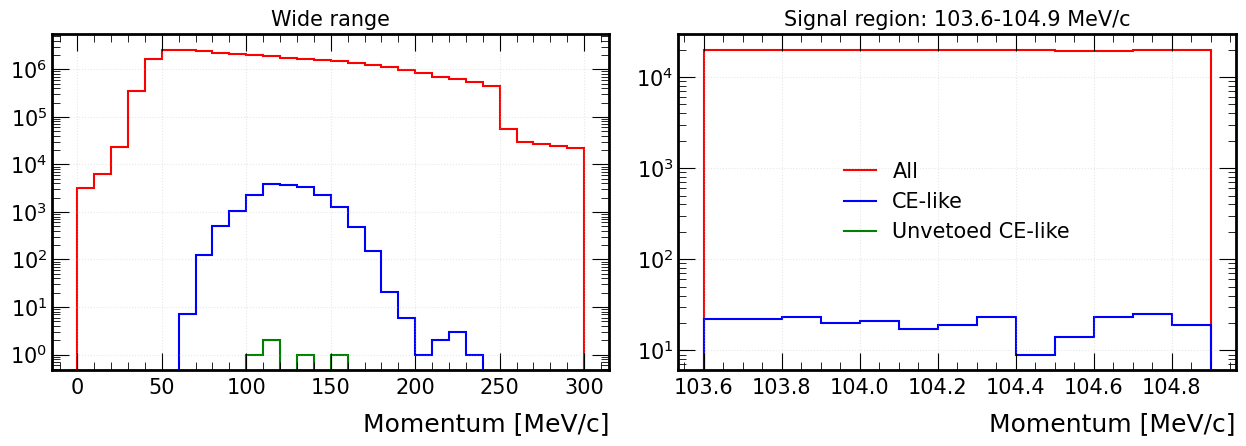

In [13]:

# Now you can plot them
plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# Plot wide range in first subplot
if 'Wide range' in combined_histograms:
    h_wide = combined_histograms['Wide range']
    # Can also include "CE-like tracks"
    # h_wide = h_wide[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] # slice(-2, None)}]  # Last 2 selections
    h_wide.plot1d(overlay='selection', ax=axes[0])
    # h_wide.sum().value
    axes[0].set_title("Wide range")
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    # axes[0].legend(frameon=False, loc="best")

# Plot signal region in second subplot
if 'Signal region' in combined_histograms:
    h_signal = combined_histograms['Signal region']
    
    # h_signal = h_signal[{"selection": ["All", "CE-like", "Unvetoed CE-like"]}] 
    h_signal.plot1d(overlay='selection', ax=axes[1])
    axes[1].set_title("Signal region: 103.6-104.9 MeV/c")
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel("")  # Remove duplicate y-label
    axes[1].legend(frameon=False, loc="best")


plt.tight_layout()
plt.savefig(f"../../img/offspill/h1_ana_mom_offspill_{today}.png", dpi=300)
plt.show()

In [38]:
def count_events(label):
    h = combined_histograms["Wide range"]
    h = h[{'selection': label}]  
    return int(h.sum())

print("-"*20)
print("Type, Count")
print("All,", count_events("All"))
print("CE-like,", count_events("CE-like"))
print("Unvetoed CE-like,", count_events("Unvetoed CE-like"))
print("-"*20)
print(fr"Efficiency, {100*(1-count_events("Unvetoed CE-like")/count_events("CE-like")):.2f}±{100*np.sqrt(count_events("Unvetoed CE-like"))/count_events("CE-like"):.2f}%")

--------------------
Type, Count
All, 32216069
CE-like, 18914
Unvetoed CE-like, 5
--------------------
Efficiency, 99.97±0.01%


In [48]:
# Calculate counts and efficiency
all_count = count_events("All")
ce_like_count = count_events("CE-like") 
unvetoed_count = count_events("Unvetoed CE-like")

efficiency = 100 * (1 - unvetoed_count / ce_like_count)
efficiency_error = 100 * np.sqrt(unvetoed_count) / ce_like_count

# Create formatted output
print("-" * 31)
print(f"{'Type':<20} {'Count':>10}")
print("-" * 31)
print(f"{'All':<20} {all_count:>10}")
print(f"{'CE-like':<20} {ce_like_count:>10}")
print(f"{'Unvetoed CE-like':<20} {unvetoed_count:>10}")
print("-" * 31)
print(f"Efficiency: {efficiency:.2f}±{efficiency_error:.2f}%")
print("-" * 31)

# Create pandas DataFrame and save to CSV
data = {
    'Type': ['All', 'CE-like', 'Unvetoed CE-like'],
    'Count': [all_count, ce_like_count, unvetoed_count]
}

# Add efficiency row
efficiency_data = {
    'Type': ['Efficiency [%]'],
    'Count': [f"{efficiency:.2f}±{efficiency_error:.2f}"]
}

df = pd.DataFrame(data)
df_efficiency = pd.DataFrame(efficiency_data)
df_combined = pd.concat([df, df_efficiency], ignore_index=True)

# Save to CSV 
fout = f"../../txt/offspill/efficiency_{today}.csv"
df_combined.to_csv(fout, index=False)

print(f"Wrote {fout}")

-------------------------------
Type                      Count
-------------------------------
All                    32216069
CE-like                   18914
Unvetoed CE-like              5
-------------------------------
Efficiency: 99.97±0.01%
-------------------------------
Wrote ../../txt/offspill/efficiency_06-11-25.csv


In [49]:
def combine_arrays(results):
    """Combine filtered arrays from multiple files
    """
    arrays_to_combine = []
    # Check if we have results
    if not results:
        return None
    # Loop through all files
    for result in results: #
        array = ak.Array(result["filtered_data"])
        if len(array) == 0:
            continue

            

        # print(array["evt"]["subrun"], array["evt"]["event"])
        # 
        # Concatenate arrays
        arrays_to_combine.append(array)
    return ak.concatenate(arrays_to_combine)
    
data = combine_arrays(results)

## Sanity check

In [50]:
new = list(data["evt"]["event"])
old = [157431, 283585, 465577, 216096, 359830, 439475, 377360, 38729, 161916, 217055]
list(set(old) - set(new))

[216096, 465577, 38729, 377360, 439475]

In [52]:
printer = Print(verbose=True)

fout = f"../../txt/offspill/background_events_verbose_{today}.txt"
import sys 
# Redirect stdout to file
with open(fout, "w") as f:
    old_stdout = sys.stdout
    sys.stdout = f
    printer.print_n_events(data, n_events=len(data))
    # Restore stdout
    sys.stdout = old_stdout
    print(f"Wrote {fout}")

[pyprint] ⭐️ Initialised Print with verbose = True and precision = 1
Wrote ../../txt/offspill/background_events_verbose_06-11-25.txt


## Find parent cosmic particle ID

These are `trkmcsim` entries of rank -1, with the highest momentum. 

In [53]:
data = combine_arrays(results)
vector = Vector()

def is_cosmic_parent(data): 
    # Rank condition
    rank_condition = data["trkmc"]["trkmcsim"]["rank"] == -1
    # Then by momentum 
    mom_mag = vector.get_mag(data["trkmc"]["trkmcsim"], "mom")
    data["mom_mag"] = mom_mag
    mom_condition = mom_mag == ak.max(mom_mag, axis=-1)
    # Combine
    mask = rank_condition & mom_condition
    return mask
    
cosmic_parent_mask = is_cosmic_parent(data)
data["cosmic_parent"] = cosmic_parent_mask

# # # # print(cosmic_parent_mask)
data["trkmc"] = data["trkmc"][cosmic_parent_mask]
data["mom_mag"] = data["mom_mag"][cosmic_parent_mask]

# printer.print_n_events(data, n_events=len(data))

# For some reason we have duplicates in here, so just take the first one 
cosmic_parent_pdg = ak.flatten(data["trkmc"]["trkmcsim"]["pdg"][:,:,0])
print("cosmic_parent_pdg", cosmic_parent_pdg) 


[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
cosmic_parent_pdg [13, 13, 2112, 13, 13]


	Wrote ../../img/offspill/bar_cosmic_parents_06-11-25.png


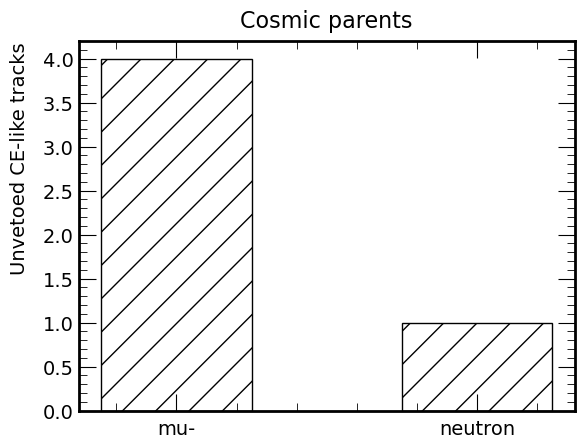

In [55]:
pdg_to_label = {
    11: "e-", -11: "e+",
    13: "mu-", -13: "mu+", 
    2112: "neutron", -2112: "antineutron",
    2212: "proton", -2212: "antiproton",
    22: "gamma", 111: "pi0",
    211: "pi+", -211: "pi-"
}

def BarChart(data, label_dict, title=None, xlabel=None, ylabel=None, fout="bar_chart.png", percentage=False, bar_alpha=1.0, bar_color='black', NDPI=300):
    """ Pulled from Mu2eCool repo 
    Needs update, but it works fine"""
    
    # Matches the key of the dict with row in the data array and returns the element as the label
    labels = [label_dict.get(p, 'other') for p in data]

    # Count occurrences of each label
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Only works for particles 

    # Sort labels and counts in descending order
    sorted_indices = np.argsort(label_counts)[::-1]
    unique_labels = unique_labels[sorted_indices]
    label_counts = label_counts[sorted_indices]

    if percentage: 
        label_counts = (label_counts / np.sum(label_counts))*100

    plt.style.use("../../../EventNtuple/utils/pyutils/mu2e.mplstyle")
    
    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the bar chart
    indices = np.arange(len(unique_labels))

    # TODO: handle this better
    n_bars = len(indices)
    bar_width = 3.0 / n_bars
    if(n_bars == 3.0): 
        bar_width = 2.0 / n_bars
    elif(n_bars == 2.0):
        bar_width = 1.0 / n_bars

    ax.bar(indices, label_counts, align='center', alpha=bar_alpha, color=bar_color, width=bar_width, fill=False, hatch='/', linewidth=1, edgecolor='black')

    # Set x-axis labels
    ax.set_xticks(indices)
    ax.set_xticklabels(unique_labels, rotation=0) # 45)

    # Set labels for the chart
    ax.set_title(title, fontsize=16, pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=14)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=14)  # Set y-axis tick label font size

    if ax.get_ylim()[1] > 999:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.offsetText.set_fontsize(14)

    # Save the figure
    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    print("\tWrote", fout)


BarChart(
    cosmic_parent_pdg,
    pdg_to_label,
    title="Cosmic parents",
    ylabel="Unvetoed CE-like tracks",
    fout=f"../../img/offspill/bar_cosmic_parents_{today}.png"
    
)